In [105]:
import pickle
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from datetime import datetime as dt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

import statsmodels.api as sm
import statsmodels.graphics as smg
import statsmodels.stats as sm_stats
import statsmodels.tsa.api as tsa

from scipy import stats
import re
from typing import List

#### Commits Bug Classification and Analysis

In [106]:
df = pd.read_csv('full.csv', parse_dates=True, infer_datetime_format=True)

In [107]:
df['date'] = df['date'].apply(lambda x: dt.strptime(x,"%a %b %d %H:%M:%S %Y %z"))
#df['date'].apply(lambda x: dt.strptime(x,"%z "))

In [108]:
df['date'] = pd.to_datetime(df['date'], utc=True)

In [109]:
df['dday'] = df['date'].dt.date
df['wday'] = df['date'].dt.weekday
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['hour'] = df['date'].dt.hour
df['min'] = df['date'].dt.minute
df['sec'] = df['date'].dt.second

In [110]:
df = df.join(df['author'].str.split('(<)',n=2,expand=True ))

In [111]:
df = df.drop('author', axis=1)
df = df.drop(1, axis=1)
df = df.rename({0:'user', 2:'email' }, axis=1)
df['email'] = df['email'].str.strip('>')

In [112]:
df.head()

,commit,date,message,repo,dday,wday,day,month,year,hour,min,sec,user,email
0,95a86a9884e6e0a32aeffff345e39434bbb722e5,2021-03-01 15:42:01+00:00,PERF: DTA/TDA _simple_new disallow i8 values (...,pandas-dev/pandas,2021-03-01,0,1,3,2021,15,42,1,jbrockmendel,jbrockmendel@gmail.com
1,4503dac1c00e47b051defba0050ba84e58e844fc,2021-03-01 15:14:34+00:00,REF: re-use objects_to_datetime64ns in maybe_i...,pandas-dev/pandas,2021-03-01,0,1,3,2021,15,14,34,jbrockmendel,jbrockmendel@gmail.com
2,ec6abbf2b4210c3b4b813a17916f328047b1f2a3,2021-03-01 14:37:35+00:00,update pre-commit-config (#40125),pandas-dev/pandas,2021-03-01,0,1,3,2021,14,37,35,Marco Gorelli,m.e.gorelli@gmail.com
3,6c69a84793fe5b9b45cc8ceb7c74f5a9fa4cb4f2,2021-03-01 13:56:52+00:00,Ensure more const typing (#40119),pandas-dev/pandas,2021-03-01,0,1,3,2021,13,56,52,Matthew Roeschke,emailformattr@gmail.com
4,8f8790737387ecb22cadfca6e692fc2bba79dbc5,2021-03-01 13:56:08+00:00,BENCH: collect low-dependency asvs (#39917),pandas-dev/pandas,2021-03-01,0,1,3,2021,13,56,8,jbrockmendel,jbrockmendel@gmail.com


In [113]:
df.head()

,commit,date,message,repo,dday,wday,day,month,year,hour,min,sec,user,email
0,95a86a9884e6e0a32aeffff345e39434bbb722e5,2021-03-01 15:42:01+00:00,PERF: DTA/TDA _simple_new disallow i8 values (...,pandas-dev/pandas,2021-03-01,0,1,3,2021,15,42,1,jbrockmendel,jbrockmendel@gmail.com
1,4503dac1c00e47b051defba0050ba84e58e844fc,2021-03-01 15:14:34+00:00,REF: re-use objects_to_datetime64ns in maybe_i...,pandas-dev/pandas,2021-03-01,0,1,3,2021,15,14,34,jbrockmendel,jbrockmendel@gmail.com
2,ec6abbf2b4210c3b4b813a17916f328047b1f2a3,2021-03-01 14:37:35+00:00,update pre-commit-config (#40125),pandas-dev/pandas,2021-03-01,0,1,3,2021,14,37,35,Marco Gorelli,m.e.gorelli@gmail.com
3,6c69a84793fe5b9b45cc8ceb7c74f5a9fa4cb4f2,2021-03-01 13:56:52+00:00,Ensure more const typing (#40119),pandas-dev/pandas,2021-03-01,0,1,3,2021,13,56,52,Matthew Roeschke,emailformattr@gmail.com
4,8f8790737387ecb22cadfca6e692fc2bba79dbc5,2021-03-01 13:56:08+00:00,BENCH: collect low-dependency asvs (#39917),pandas-dev/pandas,2021-03-01,0,1,3,2021,13,56,8,jbrockmendel,jbrockmendel@gmail.com


In [114]:
print(len(df['repo'].unique()))
df['repo'].unique()

32


array(['pandas-dev/pandas', 'kubernetes/kubernetes', 'apple/swift',
       'numpy/numpy', 'apache/httpd', 'nodejs/node', 'angular/angular',
       'rust-lang/rust', 'opencv/opencv', 'openbsd/src', 'python/cpython',
       'llvm/llvm-project', 'matplotlib/matplotlib',
       'jupyterlab/jupyterlab', 'tidyverse/ggplot2', 'golang/go',
       'denoland/deno', 'gcc-mirror/gcc', 'tensorflow/tensorflow',
       'scikit-learn/scikit-learn', 'pytorch/pytorch',
       'postgres/postgres', 'scipy/scipy', 'freebsd/freebsd-src',
       'facebook/react', 'torvalds/linux', 'rstudio/rstudio',
       'ipython/ipython', 'nginx/nginx', 'microsoft/TypeScript',
       'apache/spark', 'microsoft/vscode'], dtype=object)

In [115]:
ustats = df.groupby('repo').nunique()

In [116]:
ustats = ustats.sort_values(by="message", ascending=False)

Text(0.5, 1.0, 'Count of Users')

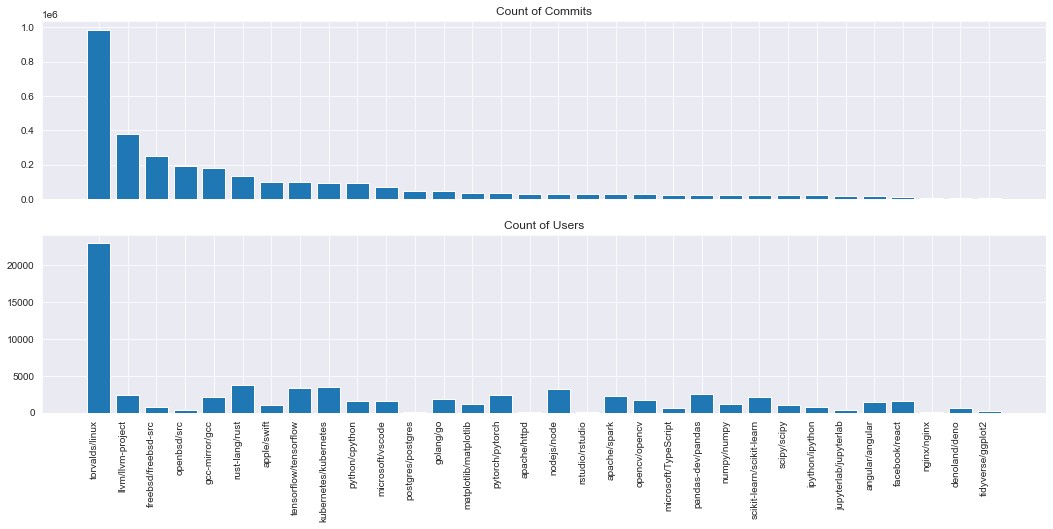

In [117]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(18,8))
fig.autofmt_xdate(rotation=90)
ax1.bar(x=ustats.index, height=ustats['message'])
ax1.set_title('Count of Commits')
ax2.bar(x=ustats.index, height=ustats['user'])
ax2.set_title('Count of Users')

<AxesSubplot:xlabel='repo'>

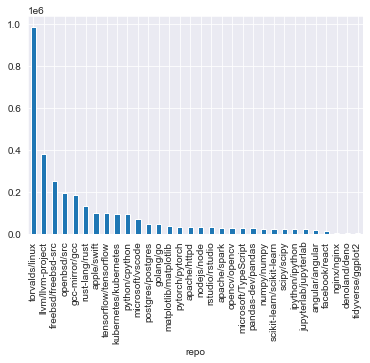

In [118]:
ustats['message'].plot.bar()

<AxesSubplot:xlabel='repo'>

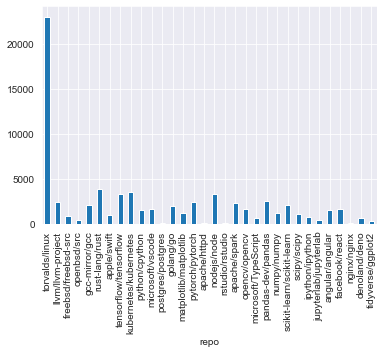

In [119]:
ustats['user'].plot.bar()

<AxesSubplot:xlabel='user', ylabel='message'>

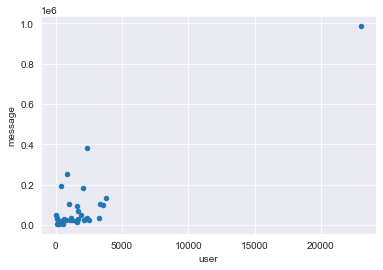

In [120]:
ustats.plot.scatter(x='user',y='message')

<AxesSubplot:xlabel='user', ylabel='message'>

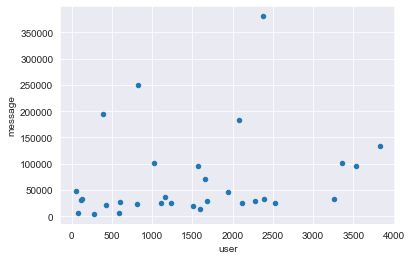

In [121]:
ustats.drop('torvalds/linux').plot.scatter(x='user',y='message') 

<AxesSubplot:xlabel='repo'>

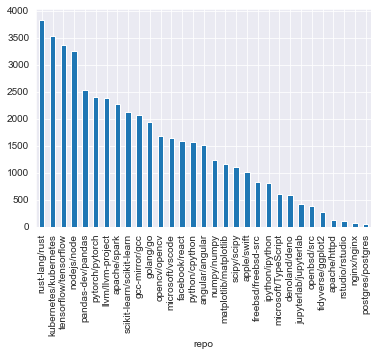

In [122]:
ustats.drop('torvalds/linux').sort_values(by='user',ascending=False)['user'].plot.bar()

<AxesSubplot:xlabel='repo'>

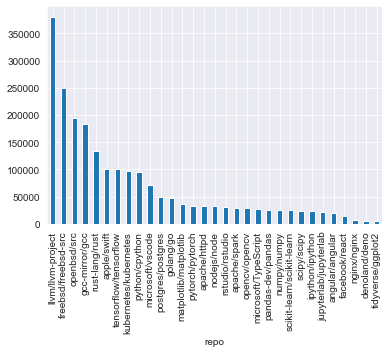

In [123]:
ustats.drop('torvalds/linux').sort_values(by='message',ascending=False)['message'].plot.bar()

In [124]:
df_user = df[['dday','repo','user']].drop_duplicates()

In [125]:
user_day = df_user.pivot_table(index='dday', columns='repo', values='user', aggfunc='count', fill_value=0, margins=True)

In [126]:
test = df.loc[1:100]
test

,commit,date,message,repo,dday,wday,day,month,year,hour,min,sec,user,email
1,4503dac1c00e47b051defba0050ba84e58e844fc,2021-03-01 15:14:34+00:00,REF: re-use objects_to_datetime64ns in maybe_i...,pandas-dev/pandas,2021-03-01,0,1,3,2021,15,14,34,jbrockmendel,jbrockmendel@gmail.com
2,ec6abbf2b4210c3b4b813a17916f328047b1f2a3,2021-03-01 14:37:35+00:00,update pre-commit-config (#40125),pandas-dev/pandas,2021-03-01,0,1,3,2021,14,37,35,Marco Gorelli,m.e.gorelli@gmail.com
3,6c69a84793fe5b9b45cc8ceb7c74f5a9fa4cb4f2,2021-03-01 13:56:52+00:00,Ensure more const typing (#40119),pandas-dev/pandas,2021-03-01,0,1,3,2021,13,56,52,Matthew Roeschke,emailformattr@gmail.com
4,8f8790737387ecb22cadfca6e692fc2bba79dbc5,2021-03-01 13:56:08+00:00,BENCH: collect low-dependency asvs (#39917),pandas-dev/pandas,2021-03-01,0,1,3,2021,13,56,8,jbrockmendel,jbrockmendel@gmail.com
5,497553d69a725b18020b4b7ab68deea9d5041c0e,2021-03-01 13:55:57+00:00,CLN: remove conda recipe (#40128)\n \n C...,pandas-dev/pandas,2021-03-01,0,1,3,2021,13,55,57,Fangchen Li,fangchen.li@outlook.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,88bcd2d1e066958b8bd7210e81771538cc3bdd4c,2021-02-22 22:59:23+00:00,Fix regression for setitem not aligning rhs wi...,pandas-dev/pandas,2021-02-22,0,22,2,2021,22,59,23,patrick,61934744+phofl@users.noreply.github.com
97,47352ea4714d413c1cfc7996e8631111863996a2,2021-02-22 22:58:04+00:00,TST: collect tests by method (#39976),pandas-dev/pandas,2021-02-22,0,22,2,2021,22,58,4,jbrockmendel,jbrockmendel@gmail.com
98,1c309c4bf8d878f153489da6789b88f4702d373a,2021-02-22 22:57:16+00:00,CI: conditional xfail flaky test (#39964),pandas-dev/pandas,2021-02-22,0,22,2,2021,22,57,16,jbrockmendel,jbrockmendel@gmail.com
99,2f73c7a4cd97a4a242300ca7916be718aad7b981,2021-02-22 22:30:48+00:00,CLN: Remove some duplicated tests and parametr...,pandas-dev/pandas,2021-02-22,0,22,2,2021,22,30,48,patrick,61934744+phofl@users.noreply.github.com


In [127]:
regex_list : List[str]

SCHEMA_NAME = 'general'
file_scheme = '([a-zA-Z0-9_\*\.])+\.[a-zA-Z]{1,4}'

REGULAR_SUFFIX = '(?:s|ed|ing)?'
VERB_E_SUFFIX = '(?:e|es|ed|ing)'

NEAR_ENOUGH = '[\S\s]{0,40}'

#term_seperator = "(\s|\.|\?|\!|\[|\]|\(|\)|\:|^|$|\,|\'|\"|/|#|\$|\%|&|\*|\+|=|`|;|<|>|@|~|{|}|-|\|)" # Adding - should be tuned
#term_seperator = "(\s|\.|\?|\!|\[|\]|\(|\)|\:|^|$|\,|\'|\"|/|#|\$|\%|&|\*|\+|=|`|;|<|>|@|~|{|}|\|)"
#term_seperator = "[^abcdefghijklmnopqrstuvwxyz]"
term_seperator = "(\s|\.|\?|\!|\[|\]|\(|\)|\:|^|$|\,|\'|\"|/|#|\$|\%|&|\*|\+|=|`|;|<|>|@|~|{|}|_|\|)"
#term_seperator = "(\s|\.|\?|\!|\[|\]|\(|\)|\:|^|$|\,|/|#|\$|\%|&|\*|\+|=|`|;|<|>|@|~|{|}|_|\|)" # no ",'
#term_seperator = "(\s|\.|\?|\!|\[|\]|\(|\)|\:|^|$|\,|\'|\"|#|\$|\%|&|\*|\+|=|`|;|<|>|@|~|{|}|_|\|)" # without /

# Negation
negation_terms = ["aren't",
 'arent',
 "can't",
 'cannot',
 'cant',
 'could not',
 "couldn't",
 'couldnt',
 "didn't",
 'didnt',
 "doesn't",
 'doesnt',
 "don't",
 'dont',
 "hasn't",
 "haven't",
 "isn't",
 'isnt',
 'lack',
 "n't",
 'never',
 'no',
 'nobody',
 'none',
 'not',
 'nothing',
 "shouldn't",
 'shouldnt',
 "weren't",
 'werent',
 'without',
 "won't",
 'wont',
 "wouldn't",
 'wouldnt']

# TODO - consider adding if, maybe
modals = ['can', 'could', 'ha(?:ve|s|d)', 'may', 'might', 'must', 'need', 'ought', 'shall'
    , 'should', 'will', 'would']



# Referred docs from https://arxiv.org/pdf/2001.09148.pdf for security terms

security_terms = [
 'advisory',
 'attack',
 'authenticat(e|ion)',
 'brute force', # consider
 'bug bount(y|ies)',
 'bypass', # consider
 'constant time',
 'crack',
 'credential(s)?',
 'cross-origin',
 'cross site',
 'cve(-d+)?(-d+)?',
 'clickjack',
 'cyber',
 'denial of service',
 '(de)?serializ', # consider
 'directory traversal',
 'dos', # consider
 'exploit',
 'expos(e|ing)',
 'hack',
 'hijack',
 'harden',
 #'infinite loop', # consider
 'injection',
 '(in)?secur(e|ity)',
 'lockout',
 'malicious',
 'malware',
 'nvd' # NVD
 'open redirect',
 'osvdb', # OSVDB
 'overflow', # consider
 'password(s)?',
 'permission(s)?',
 'poison',
 'port scan',
 'privilege',
 # 'proof of concept', # consider
 'rce', # remote code execution
 'redos' # ReDoS
 'remote code execution',
 'return oriented programming',
 'security',
 'session fixation',
 'spoof',
 'threat',
 'timing', # consider
 'traversal',
 'unauthori[z|s]ed',
 'vulnerabilit(?:y|ies)',
 'x(?: |-)frame(?: |-)options',
 'xss',
 'xsrf', # XSRF
 'xxe' # XXE
    ]


documentation_entities = [
    'change(?:s)?(?: |-)?(list|log|set|file)',
    'comment(s)?',
    'copy(?: |-)?right(?:s)?',
    'doc(?:s)?',
    'documentation',
    'explanation(?:s)?',
    'man(?: |-)?page(?:s)?',
    'manual',
    'note(?:s)?',
    'readme(?:.md)?',
    r'[-a-z\d_/\\]*.(md|txt)',
    'translation(?:s)?',
    'java(?: |-)?doc(?:s)?',
    'java(?: |-)?documentation',
    'example(?:s)?',
    'diagram(?:s)?',
    'guide(?:s)?',
    'gitignore',
    'icon(?:s)?',
    'doc(?: |-)?string(?:s)?',
    'tutorials(?:s)?',
    'help',
    'man',
    'doc(?: |-)?string(?:s)?',
    'desc(?:ription)?(?:s)?',
    'copy(?: |-)?right(?:s)?',
    'explanation(?:s)?',
    'release notes',
    'tag(?:s)?', # Git commit tags

]

prefective_entities = documentation_entities +[
    'indentation(?:s)?'
    , 'style'
    , 'todo(s)?'
    , 'typo(s)?'
    , 'verbosity']

software_goals = ['abstraction', 'coherence', 'cohesion', 'complexity', 'correctness', 'coupling', 'dependability'
    , 'duplication', 'efficiency', 'extensibility', 'flexibility' ,'maintainability', 'naming', 'performance', 'portability', 'quality'
    , 'readability', 'reliability', 're(?:-| )?use' ,'re(?:-| )?usability', 'security', 'simplicity', 'testability', 'testable', 're(?:-| )?usable'
    , 'readable', 'portable', 'maintainable', 'flexible', 'efficient', 'encapsulation'
                  ]

software_goals_modification = [
    'better','improv(?:e|es|ed|ing)', 'increas(?:e|es|ed|ing)', 'reduc(?:e|es|ed|ing)', 'worse', 'make', 'more', 'less'
]

software_entities = ['algorithm(?:s)?',
 'class(?:es)?',
 'collection(?:s)?',
 'constant(?:s)?',
 'constructor(?:s)?',
 'field(?:s)?',
 'function(?:s)?',
 'interface(?:s)?',
 'member(?:s)?',
 'method(?:s)?',
 'module(?:s)?',
 'parameter(?:s)?',
 'procedure(?:s)?',
 'routine(?:s)?`',
 'structure(?:s)?',
 'template(?:s)?',
 'type(?:s)?',
 'unit(?:s)?',
]

software_terms = [ 'assertion(?:s)?', 'assignment(?:s)?',  'code',  'conditional(?:s)?',  'control', 'definition(?:s)?'
    , 'delegate', 'delegation'
    , 'design pattern(?:s)?', 'error(?:-| )?code(?:s)?', 'exception(?:s)?',  'flag(?:s)?',  'getter(?:s)?'
    , 'guard clause(?:s)?', 'hierarch(?:y|ies)', 'implementation(?:s)?', 'inheritance', 'inline'
    ,  'internal', 'macro(?:s)?'
    , 'magic number(?:s)?', 'modifier(?:s)?', 'null object(?:s)?', 'object(?:s)?'
    , 'patch(?:es)?',  'pointer(?:s)?', 'polymorphism', 'quer(?:y|ies)',  'reference(?:s)?'
    , 'ref(?:s)?'
    , 'return type', 'setter(?:s)?', 'static',  'sub(?:-| )?class(?:es)?', 'super(?:-| )?class(?:es)?'
    , '(?:sub)?(?:-| )?system(?:s)?'
    , 'uninline'
    #, 'value(?:s)?'
    , 'variable(?:s)?', 'handler', 'plugin'
    #, '(?:in)?validation'
    #, 'input', 'output'
    , 'contravariant', 'covariant'
                  # , 'link(?:s)?'
    ,
                  'action(?:s)?'
                  # , 'event(?:s)?'
    , 'queue(?:s)?', 'stack(?:s)?'
    #, 'change(?:\s)?log'
    , 'driver(?:s)?'
    #, 'hook(?:s)?'
    #, 'target(?:s)?'
    , 'storage', 'tool(?:s)?',  'log(?:s)?', 'setting(?:s)?'
    #, '(?:index|indexes|indices)'
    , 'fall(?: |-)back(?:s)?', 'memory', 'param(?:s)?', 'volatile', 'file(?:s)?'
    , 'generic(?:s)?'
    #, 'test(?:s)?'
    , 'initialization(?:s)?', 'public', 'protected', 'private' ,'framework', 'singelton', 'declaration(?:s)?'
    , 'init' , 'destructor(?:s)?', 'instances(?:s)?', 'primitive(?:s)?'
    #, 'middle man'
    #, 'hierarchy'
                  ] + software_entities


# Well, we need them...
unneeded_Terms = ['unnecessary', 'unneeded', 'unused', '(?:not|never|no longer) used'
    #, 'old'
    , 'no longer needed', 'redundant', 'useless', 'duplicate(?:d)?', 'deprecated', 'obsolete(?:d)?', 'commented']


static_analyzers = ['lint', 'pylint', 'tslint', 'jlint', 'jslint', 'eslint', 'klint', 'xlint', 'linter']

code_review_fixes = ['(cr|pr)(s)?(-)?(d+)?\sfix(es)?', 'fix(?:ing|es|ed)?\s(cr|pr|code review|code-review|review)']

no_message = ['no message', 'wip', 'work in progress', 'message', 'change(?:-|\s)?set', 'commit']

programming_languges = [i.lower() for i in ['Python', 'JavaScript', 'Java', 'C\+\+', 'PHP', 'TypeScript', 'C',
       'C\#', 'Go', 'Ruby', 'HTML', 'Shell', 'CSS', 'Kotlin', 'Scala',
       'Swift', 'Jupyter Notebook', 'Rust', 'Perl', 'Lua', 'Haskell', 'R',
       'Objective\-C', 'Groovy', 'Vue', 'PowerShell', 'TSQL', 'Dart',
       'Clojure', 'MATLAB', 'Emacs Lisp', 'OCaml', 'Erlang', 'Elixir',
       'CoffeeScript', 'TeX', 'Fortran', 'Assembly', 'Vim script',
       'PLpgSQL', 'Makefile', 'Julia', 'BitBake', 'F\#', 'Common Lisp',
       'Vala', 'Coq', 'Smalltalk', 'Scheme', 'Visual Basic .NET',
       'Puppet', 'HCL', 'Smarty', 'Dockerfile', 'XSLT', 'GLSL', 'Haxe',
       'Cuda', 'Ada', 'SQF', 'Pascal', 'PLSQL', 'Gherkin', 'Jsonnet',
       'Nix', 'Roff', 'Apex', 'QML', 'CMake', 'D', 'Perl 6',
       'Visual Basic', 'Objective\-C\+\+', 'Prolog', 'Mathematica',
       'Batchfile', 'Reason', 'Markdown', 'DM', 'Elm', 'FreeMarker',
       'ABAP', 'M4', 'SystemVerilog', 'AutoHotkey', 'Verilog', 'IDL',
       'Tcl', 'Rich Text Format', 'SaltStack', 'UnrealScript', 'Zig',
       'WebAssembly', 'RAML', 'F\*', 'Stan', 'ColdFusion', 'Factor',
       'LLVM', 'Pike', 'VBA', 'Isabelle', 'OpenSCAD', 'ASP', 'Arc',
       'Racket', 'LookML', 'SMT', 'q', 'Xojo', 'ZenScript', 'Ceylon',
       'Agda', 'Limbo', 'SuperCollider', 'Pawn', 'xBase', 'JSON', 'Nim',
       'M', 'XC', 'SourcePawn', 'GDScript', 'LilyPond', 'SQLPL',
       'PostScript', "Ren'Py", 'Gnuplot', 'OpenEdge ABL',
       'Common Workflow Language', 'Xtend', 'Mercury', 'Genshi',
       'Open Policy Agent', 'RobotFramework']]


def term_separation(term_list : List, just_before =False):
    if just_before:
        sep = "%s(%s)" % (term_seperator, "|".join(term_list))
    else:
        sep = "%s(%s)%s" % (term_seperator, "|".join(term_list), term_seperator)
    return sep


def build_non_positive_linguistic(positive_re
                                  , neg=negation_terms):

    non_actionable_context = ['for(?:get|gets|got|getting)'
        , 'allow(s|ed|ing)?']


    return '(?:%s)' % "|".join([
        ('(?:%s)' + NEAR_ENOUGH + '(?:%s)') % (term_separation(modals, just_before=True)
                                      ,  positive_re)
        , ('(?:%s)' + NEAR_ENOUGH + '(?:%s)') % (term_separation(neg, just_before=True)
                                        ,  positive_re)
        , ('(?:%s)' + NEAR_ENOUGH + '(?:%s)') % (term_separation(non_actionable_context, just_before=True)
                                        ,  positive_re)
        # TODO - take care of documentation entities spereatly
        #, '(?:%s)[\s\S]{0,10}(?:%s)' % (term_separation(documentation_entities, just_before=True)
        #                                ,positive_re)
    ])


def match(commit_text, regex):
    text = commit_text.lower()

    return len(re.findall(regex, text))


def regex_to_big_query(reg_exp
                       , text_field='message'):
    # TODO - check
    # Take care of encoding
    reg_exp = reg_exp.replace("\\", "\\\\").replace("'", "\\'")
    #reg_exp = reg_exp.replace("\\\\", "\\")
    # No need for grouping
    reg_exp = reg_exp.replace("(?:", "(")
    str = "(" + "LENGTH(REGEXP_REPLACE(lower(" + text_field + ")," + "'%s', '@'))" % reg_exp + "-" \
          + "LENGTH(REGEXP_REPLACE(lower(" + text_field + ")," + "'%s', ''))" % reg_exp + ")"

    return str


def generate_bq_function(func_name
                         , code_generator
                         , commit: str ='XXX'):
    print("# Run in Standard sql ")
    print("CREATE OR REPLACE FUNCTION ")
    print(func_name)
    print(" (message string) ")
    print(" RETURNS int64 ")
    print("AS (")
    print("# Model language based on commit: {commit} ".format(commit=commit))
    code_generator()
    print(" ) ")
    print(" ; ")


def normalize(string):
    string = re.sub(r"\s+", " ", string.strip())
    while "  " in string:
        string = string.replace("  ", " ")
    return string

def print_logic_to_bq(regex_func
                      , concept):
    print("# " + concept)
    print( regex_to_big_query(regex_func()))
    print("# " + concept + " - end")

In [128]:
cc_adaptive_terms = ['feat' # Feature
                        , 'build'
                        , 'chore'
                        , 'ci' # continuous integration
                        , 'test'
                        , 'perf' # performance
                     ]
cc_corrective_terms = ['fix']
cc_perfective_terms = ['docs', 'style']
cc_refactor_terms = ['refactor']

cc_actions = cc_adaptive_terms + cc_corrective_terms + cc_perfective_terms + cc_perfective_terms

cc_etc = ['breaking\s+change(!)?:']


def cc_title(astions):

    return '^(' + "|".join(astions) +")(\(.*\))?(!)?:"


# Adaptive
def build_cc_adaptive_regex():

    return cc_title(cc_adaptive_terms)


def is_cc_adaptive(commit_text):

    return len(re.findall(build_cc_adaptive_regex(), commit_text)) > 0


# Corrective
def build_cc_corrective_regex():

    return cc_title(cc_corrective_terms)


def is_cc_corrective(commit_text):

    return len(re.findall(build_cc_corrective_regex(), commit_text)) > 0

# Refactor
def build_cc_refactor_regex():

    return cc_title(cc_refactor_terms)


def is_cc_refactor(commit_text):

    return len(re.findall(build_cc_refactor_regex(), commit_text)) > 0

# Just Perfective
def build_cc_just_perfective_regex():

    return cc_title(cc_perfective_terms)


def is_cc_just_perfective(commit_text):

    return len(re.findall(build_cc_just_perfective_regex(), commit_text)) > 0

# Perfective
def build_cc_perfective_regex():

    return "(" + "|".join([build_cc_refactor_regex()
                              , build_cc_just_perfective_regex()]) + ")"


def is_cc_perfective(commit_text):

    return len(re.findall(build_cc_perfective_regex(), commit_text)) > 0

# CC message
def build_cc_message_regex():

    return "(" + "|".join([cc_title(cc_actions)] + cc_etc) + ")"



def is_cc_message(commit_text):

    return len(re.findall(build_cc_message_regex(), commit_text)) > 0




def print_cc_functions_for_bq(commit: str = 'XXX'):

    concepts = {'cc_adaptive' : build_cc_adaptive_regex
                , 'cc_corrective' : build_cc_corrective_regex
                , 'cc_refactor' : build_cc_refactor_regex
                , 'cc_just_perfective' : build_cc_just_perfective_regex
                , 'cc_perfective' : build_cc_perfective_regex
                , 'cc_message' : build_cc_message_regex
                }

    for i in concepts.keys():
        print()
        print_func = lambda : print_logic_to_bq(regex_func=concepts[i]
                                                , concept=i)
        generate_bq_function('{schema}.bq_{concept}'.format(schema=SCHEMA_NAME
                                                            , concept=i)
                             , print_func
                             , commit=commit)
        print()



In [129]:
core_bug_terms = [
             'bug(s|z)?',
             'bug(?:-|\s)?fix(es)?',
             'defect(?:s)?',
             'error(?:s)?',
             'failur(?:ing|e|es|ed)',
             'fault(s)?',
             'fix(ed|es|ing)?',
             'fixing(?:s)?',
             'incorrect(ly)?',
             'mistake(s|n|d|nly)?',
             'problem(?:s)?',
             ]
# Positive
bug_terms = ['actual.*expected',
             '((assignment|assign|=) in if|== instead of =)',
             'expected.*actual'
             '(choose|take|set|use)\\s*(the|a)?\\s*correct', # correct as adjective
             "(not|isn't|doesn't)\\s+work(s|ing)?", # TODO - check with negation
             "doesn't recognize", # TODO Extend
             'double(?:-| )allocat(?:e|ion|ions)',
             'double(?:-| )free(?:s)?',
             "caused a regression", # TODO Extend
             'bad initialization(?:s)?',
             'buffer overflow(?:s)?',
             'fixme(?:s)?',
             'fixes(?:-| )?commit(?::| )?',
             '(break|breaks|broke|broked|breaking|broken)[\s\S]{0,20}(code|system|function|method)',
             '(this|that|it)\s(break|breaks|broke|broked|breaking|broken)',
             'break strict(?:-|\s)aliasing rule(s)?',
             'crash(?:ing|s|ed)?',
             'correct(?:ing|s|ed)?\\s*(a|the|some|few|this)', # make sure that correct serves as a verb
             'correct(ed|ion|ly|s)?',
             '(dangling|hanging) pointer(?:s)?',
             'deadlock(?:s)?',
             '(divid(e|es|ed|ing)|division) by (zero|0)',
             'double(?:-| )free',
             'fail(?:ing|s|ed)?',
             'faulty initialization(?:s)?',
             'fix(?:-| )?in(?:s)?',
             'fix(?:-| )?up(?:s)?',
             'flaw(?:s|ed)?',
             '(float|integer) (under|over)(?:-| )?flow',
             'hot(?:-| )?fix(?:ed|es|ing)?',
             #'hang',
             'heap overflow(?:s)?',
             '(?:im|im-)?proper'
             'memory(?:-| )?leak(?:s)?',
             'missing\s(default value|initialization|switch case)(?:s)?',
             'is\smissing',
             'add(?:ing|s|ed)?\smiss(?:ing|es|ed)?',
             #'must not',
             'npe(?:s)?'
             'null pointer(?:s)?',
             'off(?:-| )by(?:-| )(one|1)',
             'out of bound(?:s)?',
             'over(?:-| )?run(?:s)?',
             'patch(?:ed|ing)',
             #'prevent(?:ing|s|ed)?', # should be tuned
             'race condition(?:s)?',
             'data race(?:s)?',
             'repair(?:ing|s|ed)?',
             'resource leak(?:s)?',
             # TODO - check generalization to leaks works in the other direction to expected (reduces FP, increases FN)
             'leak(?:s)?',
             'revert(?:ing|s|ed)?',
             'segmentation (fault|violation)(?:s)?',
             'resolv(?:ing|e|es|ed)',
             #'solv(?:ing|e|es|ed)',
             'workaround(?:s)?',
             'wrong(nly)?',
             '(type(s)? mis(?:-| )?match|(not|non|none) matching type(s)?)',
             'trouble(?:s)?',
             '(un(?:-| )?|not )initialized variable(s)?',
             'unintended',
             'not intended',
             'unintentionally',
             'not intentionally',
             # 'unexpected.*occurred', # very rare, 90% are bugs anyway
             'vulnerabilit(?:y|ies)'
             ] + core_bug_terms

# Valid_fix_objects
valid_fix_object = prefective_entities + ['#',
                    '(camel|snake|kebab|flat|lower|upper)\\s*case',
                    "code review('s|s)?",
                    'comment(?:s)?',
                    'cosmetic(?:s)?',
                    'cr(s)?(?:-)?',
                    'documentation(?:s)?',
                    #'exception(?: |-)?handling',
                    #'format(s|ing)? fix(ed|es|ing)?',
                    'format(?:ing)?',
                    'help',
                    'remark(s)?',
                    'space(s)?',
                    'style|styling',
                    'typo(s)?',
                    'typing(?: |-)?(error|mistake)(s)?',
                    'warning(s)?',
                    'white(?: |-)?space(s)?']

valid_terms = [
    'break\sout',
    'error(?: |-)?check(ing)?',
    'error(?: |-)?handling',
    'error message(s)?',
    'error report(s|ing)?',
    'fixed(?: |-)?point',
    'fix(?:ed) ticket(?:s)?',
    #'format(ing)?',
    '(?:fix(?:ed|es)?|bug)(?: )?(?: |-|=|:)(?: )?[a-z]{0,3}(?:-)?\d+' + term_seperator,
    '(if|would)[\s\S]{0,40}go wrong',
    'line(?:s)? break(?:s)?',
    'typo(s)?\sfix(es)?',
    'fix(ed|es|ing)?' + term_separation(software_entities) + 'name(s)?',
    term_separation(static_analyzers) + 'fix(es|ed)?',
    'fix(es|ed)?' + term_separation(static_analyzers) ,
    '^### Bug Fix', # tends to be a title, later stating if the commit is a bug fix
    'edit the jira link to the correct issue', # Another occurring title
    'page(?:s)? break(?:s)?',


] + code_review_fixes



fixing_verbs = ['correct(?:ing|s|ed)'
                    , 'fix(ed|s|es|ing)?'
                    , 'repair(?:ing|s|ed)?'
                    ,  'revert(?:ing|s|ed)?'
                    , 'resolv(?:ing|e|es|ed)'
                    , 'revok(?:ing|e|es|ed)'
                    , 'und(?:oing|id)'
                ]
MERGE_PREFIX = '(merge (branch|pull request).{0,25}|merge (branch|pull request).{0,25}(from|into).{0,25})'
END_OF_LINE = r'(\r\n|\r|\n|$)'
corrective_header_entities = fixing_verbs + [
    'miss(?:ing|es|ed)?', 'should', 'must', '(have|has) to', 'avoid', 'prevent', 'break(s|ed|ing)?', 'broken'
    , 'remov(?:ing|e|es|ed) change(?:s)?', 'unable', 'proper(?:ly)?'
    , MERGE_PREFIX + "(%s)" % "|".join(core_bug_terms) + '.{0,250}' + END_OF_LINE
    #, "(does not|doesn't) need" , "cannot", "can not"
 ] #+ [ "do not" ,"don't", "dont"]

Regex Functions

In [130]:
def term_separation(term_list : List, just_before =False):
    if just_before:
        sep = "%s(%s)" % (term_seperator, "|".join(term_list))
    else:
        sep = "%s(%s)%s" % (term_seperator, "|".join(term_list), term_seperator)
    return sep

In [131]:
def build_valid_find_regex():
    fix_re = "(" + "|".join(fixing_verbs + [MERGE_PREFIX]) + ")"
    prefix = term_seperator + fix_re + '[\s\S]{1,40}' + "(" + "|".join(valid_fix_object) + ")" + term_seperator

    suffix = term_seperator + "(" + "|".join \
        (valid_fix_object) + ")" + term_seperator + '[\s\S]{0,40}' + term_seperator + fix_re + term_seperator

    # TODO - check seperation
    #sepertion = '(?:%s|%s[\s\S]{0,40}%s)' % (term_seperator, term_seperator, term_seperator)
    #suffix = "(" + "|".join \
    #    (valid_fix_object) + ")" + sepertion + fix_re + term_seperator

    #other_valid_re = "(%s)" % "|".join(valid_terms)
    other_valid_re = term_separation(valid_terms)
    return "((%s)|(%s)|(%s))" % (prefix, suffix, other_valid_re)

In [132]:
def build_bug_fix_regex(use_conventional_commits=True):
    header_regex =  '(?:^|^[\s\S]{0,25}%s)(?:%s)%s' % (term_seperator
                                                       , "|".join(corrective_header_entities)
                                                       , term_seperator)
   # strict_header = "^(?:%s)%s"  % ( "|".join([ "do not" ,"don't"])
   #                                                    , term_seperator)

    bug_fix_re = term_separation(bug_terms)


    if use_conventional_commits:
        agg_re = "((%s)|(%s)|(%s))" % (bug_fix_re, header_regex, build_cc_corrective_regex())
    else:
        agg_re = "((%s)|(%s))" % (bug_fix_re, header_regex)

    return agg_re

In [133]:
def build_negeted_bug_fix_regex():
    bug_fix_re = build_bug_fix_regex(use_conventional_commits=False)
    negation_re = term_separation(negation_terms)


    return "%s[\s\S]{0,20}%s" % (negation_re, bug_fix_re)

In [134]:
def build_core_bug_regex():

    return '(%s)' % term_separation(core_bug_terms)


## Classification Functions

In [135]:
def is_core_bug(commit_text):
    text = commit_text.lower()

    cnt = len(re.findall(build_core_bug_regex(), text))

    return cnt > 0

In [136]:
def is_fix(commit_text):

    text = commit_text.lower()
    #text = normalize(text)

    fix_num = len(re.findall(build_bug_fix_regex(), text))
    valid_num = len(re.findall(build_valid_find_regex(), text))
    negated_num = len(re.findall(build_negeted_bug_fix_regex(), text))
    # TODO  consider modals
    #negated_num = len(re.findall(build_non_positive_linguistic(build_bug_fix_regex()), text))
    return (fix_num - valid_num - negated_num) > 0
    #return (fix_num ) > 0 # max recall with current predictor

In [137]:
corrections = 0
for m in test['message']:
    print(m)
    print('CORRECTION: ' + str(is_fix(m)))
    print(' ')
    if is_fix(m) ==  True:
        corrections += 1
        
print(corrections)

REF: re-use objects_to_datetime64ns in maybe_infer_to_datetimelike (#40120)
CORRECTION: False
 
update pre-commit-config (#40125)
CORRECTION: False
 
Ensure more const typing (#40119)
CORRECTION: False
 
BENCH: collect low-dependency asvs (#39917)
CORRECTION: False
 
CLN: remove conda recipe (#40128)
    
    Co-authored-by: Fangchen Li <fangchenli@Fangchens-MacBook-Pro.local>
CORRECTION: False
 
to_offset was not using the compiled regex (#40138)
    
    Resolves #39988.
CORRECTION: True
 
[ArrayManager] TST: resample tests (#40085)
CORRECTION: False
 
TST: collect tests by method, split large tests (#40133)
CORRECTION: False
 
TST: share value_counts tests (#40132)
CORRECTION: False
 
STYLE: Inconsistent namespace - reshape (#39992) (#40058)
    
    Co-authored-by: Marco Gorelli <marcogorelli@protonmail.com>
CORRECTION: False
 
ENH: Implement unary operators for FloatingArray class (#39916)
CORRECTION: False
 
CI: skip array-manager test (#40118)
CORRECTION: False
 
BUG: format mul

In [138]:
corrections = 0
for m in test['message']:
    print(m)
    print('CORRECTION: ' + str(is_core_bug(m)))
    print(' ')
    if is_core_bug(m) ==  True:
        corrections += 1
        
print(corrections)

REF: re-use objects_to_datetime64ns in maybe_infer_to_datetimelike (#40120)
CORRECTION: False
 
update pre-commit-config (#40125)
CORRECTION: False
 
Ensure more const typing (#40119)
CORRECTION: False
 
BENCH: collect low-dependency asvs (#39917)
CORRECTION: False
 
CLN: remove conda recipe (#40128)
    
    Co-authored-by: Fangchen Li <fangchenli@Fangchens-MacBook-Pro.local>
CORRECTION: False
 
to_offset was not using the compiled regex (#40138)
    
    Resolves #39988.
CORRECTION: False
 
[ArrayManager] TST: resample tests (#40085)
CORRECTION: False
 
TST: collect tests by method, split large tests (#40133)
CORRECTION: False
 
TST: share value_counts tests (#40132)
CORRECTION: False
 
STYLE: Inconsistent namespace - reshape (#39992) (#40058)
    
    Co-authored-by: Marco Gorelli <marcogorelli@protonmail.com>
CORRECTION: False
 
ENH: Implement unary operators for FloatingArray class (#39916)
CORRECTION: False
 
CI: skip array-manager test (#40118)
CORRECTION: False
 
BUG: format mu

## Security

### Keywords

In [139]:
positive_terms = [
 'advisory',
 'attack(?:s)?',
 'auth',
 'authenticat(e|ion)',
 'brute force', # consider
 'bug bount(y|ies)',
 'bypass(?:es|ed|ing)?', # consider
 'certificate(?:s)?',
 #'constant time', # too general
 'crack',
 'credential(s)?',
 'cross(?: |-)origin',
 'cross(?: |-)site',
 'cve(-d+)?(-d+)?',
 'clickjack',
 'cyber',
 'denial of service',
 '(de)?serializ', # consider
 'directory traversal',
 'dos', # consider
 'exploit',
 #'expos(e|ing)',
 # 'hack', # A bit general, consider
 'hijack',
 'harden',
 #'infinite loop', # consider
 'injection',
 '(in)?secur(e|ity)',
 'lockout',
 'malicious',
 'malware(?:s)?', #plural of malware is malware yet not all are aware
 'nvd' # NVD
 'open redirect',
 'osvdb', # OSVDB
 'overflow', # consider
 'password(?:s)?',
 'permission(?:s)?',
 'poison(?:s|es|ed|ing)?',
 'port scan',
 'privilege(?:s)?',
 # 'proof of concept', # consider
 'rce', # remote code execution
 'redos' # ReDoS
 'remote code execution',
 'return oriented programming',
 '(?:safe|safety|unsafe|safer)',
 'security',
 'session fixation',
 'spoof(?:s|es|ed|ing)?',
 'threat(?:s|ed|ing)?',
 'timing', # consider
 'token(?:s)?',
 #'traversal',
 'unauthori[z|s]ed',
 'vulnerabilit(?:y|ies)',
 'x(?: |-)frame(?: |-)option(?:s)?',
 'xss',
 'xsrf', # XSRF
 'xxe' # XXE
    ]

excluded_terms = ['_____PLACEHOLDER_____'
                  ]

### Regex Functions

In [140]:

def exclu_regex():
    return term_separation(excluded_terms)

def non_positive_regex():
    return build_non_positive_linguistic(build_positive_regex())
def build_positive_regex():
    return term_separation(positive_terms)

### Classification Functions

In [141]:
def securityCheck(commit_text):
    return (len(re.findall(build_positive_regex(), commit_text))
            - len(re.findall(exclu_regex(), commit_text))
            - len(re.findall(non_positive_regex(), commit_text)))  > 0

In [142]:
corrections = 0
for m in test['message']:
    print(m)
    print('CORRECTION: ' + str(securityCheck(m)))
    print(' ')
    if securityCheck(m) ==  True:
        corrections += 1
        
print(corrections)

REF: re-use objects_to_datetime64ns in maybe_infer_to_datetimelike (#40120)
CORRECTION: False
 
update pre-commit-config (#40125)
CORRECTION: False
 
Ensure more const typing (#40119)
CORRECTION: False
 
BENCH: collect low-dependency asvs (#39917)
CORRECTION: False
 
CLN: remove conda recipe (#40128)
    
    Co-authored-by: Fangchen Li <fangchenli@Fangchens-MacBook-Pro.local>
CORRECTION: False
 
to_offset was not using the compiled regex (#40138)
    
    Resolves #39988.
CORRECTION: False
 
[ArrayManager] TST: resample tests (#40085)
CORRECTION: False
 
TST: collect tests by method, split large tests (#40133)
CORRECTION: False
 
TST: share value_counts tests (#40132)
CORRECTION: False
 
STYLE: Inconsistent namespace - reshape (#39992) (#40058)
    
    Co-authored-by: Marco Gorelli <marcogorelli@protonmail.com>
CORRECTION: False
 
ENH: Implement unary operators for FloatingArray class (#39916)
CORRECTION: False
 
CI: skip array-manager test (#40118)
CORRECTION: False
 
BUG: format mu

## Adaptive

### Keywords

In [143]:

core_adaptive_terms = [
    'add(?:s|ed|ing)?',
    'creat(?:e|es|ing)',
    'disabl(?:e|es|ed|ing)',
    'implement(?:ed|s|ing)?',
    'import(?:s|ed|ing)?',
    'introduc(?:e|es|ed|ing)',
    'port(?:s|ed|ing)?',
    'provid(?:e|es|ed|ing)',
    'updat(?:e|es|ed|ing)',
    'upgrad(?:e|es|ed|ing)'

]

adaptive_context = [
 '(?:un)?hid(?:e|es|den)',
 'allow(?:s|ed|ing)?',
 'buil(?:t|ds|ing)',
 'calibirat(?:e|es|ed|ing)',
 'configure',
 'deferr(?:ed|s|ing)?',
 'enhanc(?:e|es|ed|ing)',
 'extend(?:s|ed|ing)?',
 'form(?:ed|s|ing)?',
 'report(?:s|ed|ing)?',
 'support(s|ed|ing)?',

# , 'mov(e|es|ed|ing)'
# , 'print(s|ed|ing)?'

] + core_adaptive_terms



adaptive_entities = ['ability', 'configuration', 'conversion', 'debug', 'new', 'possibility', 'support'
    , 'test(s)?', 'tweak(s)?', 'mode', 'option']


adaptive_header_action = "|".join([
    'upgrad(?:e|es|ed|ing)',
    'configur(?:e|es|ed|ing)',
    'chang(?:e|es|ed|ing)',
    '(?:keep|change)\s+(?:the\s+)?default',
    'new',
    # '(?:make(?:s)?|made|making)',
    'merg(?:e|es|ed|ing)',
    'clear(?:s|ed|ing)?',
    #'comment(?:s|ed|ing)?\sout'
    'creat(?:e|es|ed|ing)',
    'cast(?:s|et|ing)?' + NEAR_ENOUGH + '\sas',
    # 'convert(?:s|ed|ing)?',
    # 'check(?:s|ed|ing)?',
    'add(?:s|ed|ing)?',
    # 'buil(?:d|t|ds|ing)',
    'Initial revision',
    '(?:im)?port(?:s|ed|ing)?',
    '(?:un)?hid(?:e|es|den)',
    'updat(?:e|es|ed|ing)',
    'upload(?:s|ed|ing)?',
    'disabl(?:e|es|ed|ing)',
    'delet(?:e|es|ed|ing)',
    'enabl(?:e|es|ed|ing)',
    'quirk(?:s|ed|ing)?',
    'skip(?:s|ed|ing)?',
    'switch(?:s|ed|ing)?',
    'allow(?:s|ed|ing)?',
    'provid(e|es|ed|ing)',

    ###
    # , 'build'
    # , 'mark(?:s|ed|ing)?'
    # , 'us(?:e|es|ed|ing)'
    # , '(?:make|made|making)'
    # , 'creat(?:e|es|ed|ing)'
    # , 'handl(?:e|es|ed|ing)'
    'remov(?:e|es|ed|ing)',
    'refresh(?:s|ed|ing)?',
    #'re(-)?enabl(?:e|es|ed|ing)',

] +no_message
)

adaptive_actions = [  # 'revert(?:s|ed|ing)?',
    #'merg(?:e|es|ed|ing)[\s\S]{1,5}(pull request|pr|branch)',
    'add(?:s|ed|ing)?[\s\S]{1,50}(?:version|v\d|ver\d)',
    #'(cr(s)?(-)?|code\sreview)\sfix(?:s|ed|ing)?',
    '(^|\s)implement(?:ed|s|ing)?\s',
    '(?:make(?:s)?|made|making)[\s\S]{1,50}consitent',
    'updat(?:e|es|ed|ing)[\s\S]{1,25}to[\s\S]{1,25}\d+.\d',
    'updat(?:e|es|ed|ing)\s+(to\s+)?\d+\.\d',
    '(?:add(s|ed|ing)?|delet(?:e|es|ed|ing)|updat(?:e|es|ed|ing))\s+' + file_scheme,
    # '(add(s|ed|ing)?|delet(e|es|ed|ing)|updat(e|es|ed|ing))\s+([A-Z0-9_]*)', # TODO - run without lower
    '(^|^[\s\S]{0,25}%s)(%s)%s' % (term_seperator, adaptive_header_action, term_seperator),
    # '^(?:version|v\d+\.\d|ver\d+\.\d)',
    '^\[(?:IMP|imp)\]',  # TODO - take care of upper/lower case
    'support(?:s|ed|ing)?\sfor\s',
    'show(?:es|ed|ing)?[\s\S]instead',
    'scal(?:e|es|ed|ing)?\s(up|down)'

                   ] + code_review_fixes

In [144]:
def build_adaptive_action_regex():

    return "(%s)" % ("|".join(
    adaptive_actions))

def build_adaptive_regex(use_conventional_commits=True):
    adaptive_context_re = term_separation(adaptive_context, just_before=True)
    base_re = "((%s)\s[\s\S]{0,50}(%s)%s)" % (adaptive_context_re
                            ,  "|".join(adaptive_entities + software_terms)
                            , term_seperator)
    if use_conventional_commits:
        agg_re = "((%s)|(%s))" % (base_re
                                  , build_cc_adaptive_regex())
    else:
        agg_re = base_re

    return agg_re



def build_non_adaptive_context():

    non_adaptive_header_action = "|".join(['transla(?:tion|et|eted|ets|ting)' ,  'readme(?:.md)?'])

    non_adaptive_header ='^[\s\S]{0,50}(%s)' % non_adaptive_header_action

    entities = documentation_entities + ['bug',
                'helper',
                'miss(?:ing|ed)',
                'to(?: |-)?do(?:s)?',
                'warning(?:s)?'
                ]

    adaptive_actions = ['remov(?:e|es|ed|ing)']
    non_adaptive_entities = documentation_entities + software_terms + unneeded_Terms + [file_scheme]


    return '(%s)' % "|".join(['(?:%s)\s[\s\S]{0,50}(?:%s)' % (term_separation(adaptive_context, just_before=True)
                                                            , "|".join(entities))
                     , non_adaptive_header
                     , '(?:%s)\s[\s\S]{0,50}(?:%s)' % (term_separation(adaptive_actions, just_before=True)
                                                            , "|".join(non_adaptive_entities))
                     ])


def build_non_adaptive_linguistic():

    return build_non_positive_linguistic(build_adaptive_regex(use_conventional_commits=False))

def build_core_adaptive_regex():

    return '(%s)' % term_separation(core_adaptive_terms)


#### Classification Functions

In [145]:
def is_adaptive(text):

    return (match(text, build_adaptive_regex())
            + match(text, build_adaptive_action_regex())
            - match(text, build_non_adaptive_context())
            - match(text, build_non_adaptive_linguistic()))


In [146]:
adaptive = 0
for m in test['message']:
    print(m)
    print('CORRECTION: ' + str(is_adaptive(m)))
    print(' ')
    if is_adaptive(m) ==  True:
        adaptive += 1
        
print(adaptive)

REF: re-use objects_to_datetime64ns in maybe_infer_to_datetimelike (#40120)
CORRECTION: 0
 
update pre-commit-config (#40125)
CORRECTION: 1
 
Ensure more const typing (#40119)
CORRECTION: 0
 
BENCH: collect low-dependency asvs (#39917)
CORRECTION: 0
 
CLN: remove conda recipe (#40128)
    
    Co-authored-by: Fangchen Li <fangchenli@Fangchens-MacBook-Pro.local>
CORRECTION: 1
 
to_offset was not using the compiled regex (#40138)
    
    Resolves #39988.
CORRECTION: 0
 
[ArrayManager] TST: resample tests (#40085)
CORRECTION: 0
 
TST: collect tests by method, split large tests (#40133)
CORRECTION: 0
 
TST: share value_counts tests (#40132)
CORRECTION: 0
 
STYLE: Inconsistent namespace - reshape (#39992) (#40058)
    
    Co-authored-by: Marco Gorelli <marcogorelli@protonmail.com>
CORRECTION: 0
 
ENH: Implement unary operators for FloatingArray class (#39916)
CORRECTION: 2
 
CI: skip array-manager test (#40118)
CORRECTION: 2
 
BUG: format multiple CSS selectors correctly (#39942)
CORRECTI

In [147]:

refactor_entities = software_terms + ['(helper|utility|auxiliary) function(?:s)?']

unneeded_Terms = ['unnecessary', 'unneeded', 'unused', '(?:not|never|no longer) used'
    , 'no longer needed', 'redundant', 'useless', 'duplicate(?:d)?', 'deprecated', 'obsolete(?:d)?', 'commented']

core_refactor_terms = [
    'clean(?:ing)?(?:-| )?up(?:s)?',
    'clean(?:ing|s|ed)?',
    'combin(?:e|es|ed|ing)',
    'compos(?:e|es|ed|ing)',
    'de(?:-| )?compos(?:e|es|ed|ing)',
    'deprecat(?:e|es|ed|ing)',
    'encapsulat(?:e|es|ed|ing)',
    'polish(?:ed|es|ing)?',
    're(?:-| )?factor(?:ed|s|ing|ings)?', 
    're(?:-|)?organiz(?:e|es|ed|ing)',
    're(?:-|)?structur(?:e|es|ed|ing)',
    'rebuil(?:d|ds|ding|t)',
    'tid(?:y|ying|ied)'
]


modification_activity = [
'(?:get|got|getting) rid',
 '(?:make|makes|made|making)',
 'convert(?:ed|s|ing)?',
 'dead',
 'drop(?:ed|s|ing)?',
 'duplicat(?:e|es|ed|ing)',
 'extract(?:ed|s|ing)?',
 'hide(?:e|es|ed|ing)',
 'improv(?:e|es|ed|ing)',    
 'increas(?:e|es|ed|ing)',
 'mov(?:e|es|ed|ing)',
 'parameteriz(?:e|es|ed|ing)',
 'redundant',
 'replac(?:e|es|ed|ing)',
 'separat(?:e|e s|ed|ing)',
 'short(:?en|er|ing|s)?',
 'split(?:s|ing)?',
 'subsitut(?:e|es|ed|ing)',
 'substitut(?:e|es|ed|ing)',
 'un(?:-| )?hid(?:e|es|ed|ing)'
] + core_refactor_terms + unneeded_Terms

feedbak_terms = [ 'py(?:-| )?lint', 'lint', 'review comments(?:s)?', 'code review', 'cr', 'pep8'
                  ]
feedback_action = ['fix(?:ed|s|es|ing)?', 'fix(?:-| )?up(?:s)?', 'resolv(?:e|ed|es|ing)', 'correct(?:ed|s|es|ing)?']

perfective_header_action = [
    '(private|public|protected|static)',
     'clean(?:ing|s|ed)?(?:-| )?up(?:s)?'
    , 'cleaner'
    , 'deprecat(?:e|es|ed|ing)'
    , 'extract(?:ed|s|ing)?',
    're(?:-|)?organiz(?:e|es|ed|ing)', 're(?:-|)?structur(?:e|es|ed|ing)', 'tid(?:y|ying|ied) up'
    , 'improv(?:e|ed|es|ing|ement|ements)' , 're(?:-|)?organiz(?:e|es|ed|ing)', 're(?:-|)?structur(?:e|es|ed|ing)'
    , '(helper|utility|auxiliary) function(?:s)?'
    , '(?:move|moved|moves|moving) to'
    , 'separat(?:e|es|ed|ing)'
    , 'split(?:s|ing)?', '->'
    , term_separation(static_analyzers) + 'fix(es|ed)?'
    , 'fix(es|ed)?' + term_separation(static_analyzers)
]

# rewrited, move into/out???, deduplicate, remove legacy, redo, PR, feedback

# clean , style, prettier, "->", refine, "Removed commented code", "More startup improvements.", recode
# ""Remove another old function", "improved redis error message", utility functions, never used
# Checkstyle


# perfective, not refactor - ident, spacing, tabs, "tabs -> spaces", cosmetic, ""*** empty log message ***"
# examples ""DOC: remove mention of TimeSeries in docs"

# add "resolving review comments"
refactor_context = [ 'clean(ing)?(-| )?up(s)?'
    ,'call(?:s|ed|ing)?[\s\S]{1,50}instead'
    , 'collaps(?:e|es|ed|ing)', 'consolidat(e|es|ed|ing)'
    , 'decompos(?:e|es|ed|ing)'
    , 'drop(?:ed|s|ing)?( back)', 'encapsulat(e|es|ed|ing)'
    , 'gereneliz(?:e|es|ed|ing)'
                    # , 'inline'
                    # , 'no longer needed', 'not used', 'obsolete(d)?'
    , 'optimiz(?:e|es|ed|ing|ation|ations)'
    , 'pull(?:ed|s|ing)? (up|down)', 're(?:-)?(?:write|wrote)', 're(?:-| )?factor(?:ed|s|ing|ings)?'
    , 're(-)?implement(ed|s|ing)?'
    , 'renam(?:e|es|ed|ing|ings)', 'better nam(?:e|es|ing)','re(?:-)?organiz(e|es|ed|ing)', 're(?:-)?organization'
    , 're(?:-)?work(ed|s|ing|ings)?'
    , 'reorg' , 'simplif(y|es|ied|ying|ication)', 'suppress(es|ed|ing)? warning(?:s)?'
    , 'unif(?:y|ies|ied|ing)', 'uninline'
    , 'beef(?:ed|s|ing)? up', 'refactor(?:ing)?(?:s)?', 'code improvement(?:s)?'
    #, '(?:^|^[\s\S]{0,25}%s)(?:%s)%s[\s\S]{0,25}$' % (term_seperator, "|".join(perfective_header_action), term_seperator)
    , 'revis(?:e|es|ed|ing)'
    , 're(?:-)?construct(?:s|ed|ing)?'
    , 're(?:-)?(?:write|write|wrote|writing)'
    , 're(?:-)?cod(?:e|ed|es|ing)'
    , 'factor(?:ed|s|ing)? out'
    , 're(?:-| )?packag(?:e|es|ed|ing)'
    #, 'code review'
    #, 'collapse'
    #, "(?:(?:%s)(?:%s|%s[\s\S]{0,50}%s)(?:%s)%s)" % (term_separation(feedback_action
    #                                                                                      , just_before=True)
    #                                                                 , term_seperator
    #                                                                 , term_seperator
    #                                                                 , term_seperator
    #                                                                 , "|".join(feedbak_terms)
    #                                                                 , term_seperator)
                    # ,'us(e|es|ed|ing)[\s\S]{1,50}(instead)'
                    # , '(instead)[\s\S]{1,50}us(e|es|ed|ing)'
                    ]
# Referred to this article for refactoring techniques https://refactoring.guru/refactoring/techniques

# TODO - change [\s\S] with . ?
removal = [ 'add(?:s|ed|ing)?[\s\S]{1,50}helper(?:s)?'
    ,  'us(?:e|es|ed|ing)[\s\S]{1,50}instead'
    #,  'us(?:e|es|ed|ing)[\s\S]{1,25}\(\)[\s\S]{1,25}instead'
    ,  'split(?:s|ing)?[\s\S]{1,50}into'
    ,  'break(?:s|ing)?[\s\S]{1,50}into'
    ,  'separat(?:e|e s|ed|ing)[\s\S]{1,50}into'
    #,  'replac(?:e|es|ed|ing)?[\s\S]{1,50}with'
    ,  'replac(?:e|es|ed|ing)?[\s\S]{1,50}(?:%s)' % "|".join(unneeded_Terms)
    , 'remov(?:e|es|ed|ing)[\s\S]{1,50}(?:%s)' % "|".join(unneeded_Terms)
    #, '(?:this|that|is)[\s\S]{1,50}(?:%s)' % "|".join(unneeded_Terms)
    ,  'kill(?:s|ed|ing)?[\s\S]{1,50}(?:%s)' % "|".join(unneeded_Terms)
    ,  'drop(?:s|ed|ing)?[\s\S]{1,50}(?:%s)' % "|".join(unneeded_Terms)
    ,  'mov(?:e|es|ed|ing)?[\s\S]{1,50}(?:%s)' % "|".join(unneeded_Terms)
            ]
adaptive_context = [
    '(?:un)?hid(?:e|es|den)', 'add(?:s|ed|ing)?', 'allow(?:s|ed|ing)?'
    , 'buil(?:t|ds|ing)', 'calibirat(?:e|es|ed|ing)'
    , 'configure'
    , 'creat(?:e|es|ing)' #   O created
    , 'deferr(?:ed|s|ing)?'
    , 'disabl(?:e|es|ed|ing)'
    , 'enhanc(?:e|es|ed|ing)', 'extend(?:s|ed|ing)?', 'form(?:ed|s|ing)?'
    , 'implement(?:ed|s|ing)?', 'import(?:s|ed|ing)?', 'introduc(?:e|es|ed|ing)'
    , 'port(?:s|ed|ing)?'
    , 'provid(?:e|es|ed|ing)'
    , 'report(?:s|ed|ing)?'
    , 'support(s|ed|ing)?'
    , 'updat(?:e|es|ed|ing)'
    , 'upgrad(?:e|es|ed|ing)'

    # , 'mov(e|es|ed|ing)'
    # , 'print(s|ed|ing)?'


]

### Regex Functions

In [148]:
def build_core_refactor_regex():

    return '(%s)' % term_separation(core_refactor_terms)

def build_refactor_regex(use_conventional_commits=True):
    header_regex =  '(?:^|^[\s\S]{0,25}%s)(?:%s)%s' % (term_seperator
                                                       , "|".join(perfective_header_action)
                                                       , term_seperator)

    activity_regerx = "(?:(?:%s)(?:%s|%s[\s\S]{0,50}%s)(?:%s)%s)" % (term_separation(modification_activity
                                                                                          , just_before=True)
                                                                     , term_seperator
                                                                     , term_seperator
                                                                     , term_seperator
                                                                     , "|".join(refactor_entities)
                                                                     , term_seperator)
    if use_conventional_commits:
        agg_re = "(%s)|(%s)|(%s)|(%s)" % (term_separation(refactor_context)
                          , activity_regerx
                          , header_regex
                          , build_cc_refactor_regex())
    else:
        agg_re = "(%s)|(%s)|(%s)" % (term_separation(refactor_context)
                          , activity_regerx
                          , header_regex)
    return agg_re



def build_refactor_goals_regex():
    goals_regerx = "(?:(?:%s)(?:%s|%s[\s\S]{0,50}%s)(?:%s)%s)" % (term_separation(software_goals_modification
                                                                                       , just_before=True)
                                                                  , term_seperator
                                                                  , term_seperator
                                                                  , term_seperator
                                                                  , "|".join(software_goals)
                                                                  , term_seperator)
    return goals_regerx


def build_non_code_perfective_regex():

    non_perfective_entities = ['warning(?:s)?'
                               , 'format(?:ing)?'
                               , 'indentation(?:s)?'
                              ]
    # TODO - applied to perfective entities too here, which is a bug.
    modification_action = ['clean(?:-| )?up(?:s)?']
    non_perfective_context = [
                            'fix(?:es|ed|ing)?'
                            ,'(?:get|got|getting) rid'
                            , 'support(?:s|ed|ing)?'
                            ]
    modifiers = modification_activity + non_perfective_context
    activity_regerx = "((?:%s)(?:\s|%s[\s\S]{0,50}%s)(?:%s))" % (term_separation(modifiers, just_before=True)
                                                                                , term_seperator
                                                                                , term_seperator
                                                                                , "|".join(prefective_entities
                                                                                           + non_perfective_entities))
    doc_header_regex =  '(?:^|^[\s\S]{0,25}%s)(?:%s)[\s\S]{0,25}(?:%s)' % (term_seperator
                                                       , "|".join(perfective_header_action)
                                                       , term_separation(documentation_entities))


    no_prefective_action = "|".join([
        'convert(?:ed|s|ing)?(?:%s|%s[\s\S]{0,50}%s)support(?:s|ed|ing)?' % (
            term_seperator,term_seperator, term_seperator)
        , '(?:make|made|making|makes)(?:%s|%s[\s\S]{0,50}%s)work' % (term_seperator, term_seperator, term_seperator)
        , '(?:make|made|making|makes)(?:%s|%s[\s\S]{0,50}%s)sense' % (term_seperator, term_seperator, term_seperator)
        , 'improv(?:e|es|ed|ing) handling'
        , 'need(?:s|ing)?\srefactor(?:ing)?'
        , '(?:%s)(?:%s|%s[\s\S]{0,50}%s)(?:%s)' %(term_separation(non_perfective_entities,just_before=True)
                                                   ,term_seperator
                                                   , term_seperator
                                                   , term_seperator
                                                   , "|".join(modification_action)
                                                   )
        , doc_header_regex

    ])
    non_perfective_context = '(?:%s|%s)' % (no_prefective_action
                                         , activity_regerx)

    return non_perfective_context


def Documentation_entities(positive_re):

    return '(?:%s)' % "|".join([
        # TODO - take care of documentation entities separatly
         '(?:%s)[\s\S]{0,10}(?:%s)' % (term_separation(documentation_entities, just_before=True)
                                        ,positive_re)
    ])

def perfect_regex():
    non_code = term_separation (prefective_entities)
    perfective = "(%s)" %  non_code

    return perfective

Classification Functions

In [149]:
def built_is_refactor(commit_text):
    removal_re = term_separation(removal)

    return (match(commit_text, build_refactor_regex())
            + match(commit_text, removal_re)
            + match(commit_text, build_refactor_goals_regex())
            - match(commit_text, build_non_code_perfective_regex())
            - match(commit_text
                    , Documentation_entities(build_refactor_regex(use_conventional_commits=False)))
            - match(commit_text
                    , build_non_positive_linguistic(build_refactor_regex(use_conventional_commits=False)))
            - match(commit_text, build_non_positive_linguistic(term_separation(removal)))
            - match(commit_text, build_non_positive_linguistic(build_refactor_goals_regex()))
            ) > 0


In [150]:
refactors = 0
for m in test['message']:
    print(m)
    print('CORRECTION: ' + str(built_is_refactor(m)))
    print(' ')
    if built_is_refactor(m) ==  True:
        refactors += 1
        
print(refactors)

REF: re-use objects_to_datetime64ns in maybe_infer_to_datetimelike (#40120)
CORRECTION: False
 
update pre-commit-config (#40125)
CORRECTION: False
 
Ensure more const typing (#40119)
CORRECTION: False
 
BENCH: collect low-dependency asvs (#39917)
CORRECTION: False
 
CLN: remove conda recipe (#40128)
    
    Co-authored-by: Fangchen Li <fangchenli@Fangchens-MacBook-Pro.local>
CORRECTION: False
 
to_offset was not using the compiled regex (#40138)
    
    Resolves #39988.
CORRECTION: False
 
[ArrayManager] TST: resample tests (#40085)
CORRECTION: False
 
TST: collect tests by method, split large tests (#40133)
CORRECTION: False
 
TST: share value_counts tests (#40132)
CORRECTION: False
 
STYLE: Inconsistent namespace - reshape (#39992) (#40058)
    
    Co-authored-by: Marco Gorelli <marcogorelli@protonmail.com>
CORRECTION: False
 
ENH: Implement unary operators for FloatingArray class (#39916)
CORRECTION: False
 
CI: skip array-manager test (#40118)
CORRECTION: False
 
BUG: format mu

# Analysis

# 2003 to 2022 Timeframes

In [151]:
df = df.loc[df['date'] > '2003-01-01'].loc[df['date'] < '2023-01-01']

In [152]:
df['date']

0         2021-03-01 15:42:01+00:00
1         2021-03-01 15:14:34+00:00
2         2021-03-01 14:37:35+00:00
3         2021-03-01 13:56:52+00:00
4         2021-03-01 13:56:08+00:00
                     ...           
3240992   2015-11-13 15:36:52+00:00
3240993   2015-11-13 14:18:17+00:00
3240994   2015-11-13 15:32:42+00:00
3240995   2015-11-13 14:48:38+00:00
3240996   2015-11-13 13:39:38+00:00
Name: date, Length: 3000345, dtype: datetime64[ns, UTC]

In [153]:
df.loc[df['date'] > '2000-01-01'].loc[df['date'] < '2021-01-01']

,commit,date,message,repo,dday,wday,day,month,year,hour,min,sec,user,email
612,c15f3df7b112350e2af19ccc5401601e54c9b722,2020-12-31 23:52:12+00:00,TST/REF: implement tests.frame.constructors (#...,pandas-dev/pandas,2020-12-31,3,31,12,2020,23,52,12,jbrockmendel,jbrockmendel@gmail.com
613,48edcad40b467a02f02072677f097dd31a03c016,2020-12-31 23:49:08+00:00,"BUG: DataFrame(dt64data, dtype=td64) corner ca...",pandas-dev/pandas,2020-12-31,3,31,12,2020,23,49,8,jbrockmendel,jbrockmendel@gmail.com
614,9b470912e8fea99cd17775d8afc5590ae1eeb50c,2020-12-31 22:13:38+00:00,"TST/REF: io/parser/(test_dtypes.py, test_useco...",pandas-dev/pandas,2020-12-31,3,31,12,2020,22,13,38,Andrew Wieteska,48889395+arw2019@users.noreply.github.com
615,bdc5a67db98878c25d6bc8a4b368a43e426a9d2c,2020-12-31 19:11:27+00:00,BUG: unstack with missing levels results in in...,pandas-dev/pandas,2020-12-31,3,31,12,2020,19,11,27,Yuanhao Geng,41546976+GYHHAHA@users.noreply.github.com
616,906d3b673cb6ddf99b7f3ee4579b8b8d5128539d,2020-12-31 18:48:27+00:00,Fix broken link in docs (#38854),pandas-dev/pandas,2020-12-31,3,31,12,2020,18,48,27,Felix Divo,felixdivo@users.noreply.github.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3240992,43a17862477d0b2b7fb825ffd2a00ac193d2f771,2015-11-13 15:36:52+00:00,jsdoc fot vscode.d.ts,microsoft/vscode,2015-11-13,4,13,11,2015,15,36,52,Johannes Rieken,johannes.rieken@gmail.com
3240993,e3281e77cb1b684787971fef7985002583ec843a,2015-11-13 14:18:17+00:00,remove commented extension reference,microsoft/vscode,2015-11-13,4,13,11,2015,14,18,17,Johannes Rieken,johannes.rieken@gmail.com
3240994,0a2f0cbc5c7ebc4573ba93c7b4c007efb1110856,2015-11-13 15:32:42+00:00,gulp-symdest does not preserve links on electr...,microsoft/vscode,2015-11-13,4,13,11,2015,15,32,42,Benjamin Pasero,benjpas@microsoft.com
3240995,6f9e2ae3907632e2f7dbbabe8da403edd6dfa120,2015-11-13 14:48:38+00:00,"Add reference to DefinitelyTyped, updated the ...",microsoft/vscode,2015-11-13,4,13,11,2015,14,48,38,Chris Dias,chris@diasfam.com


In [154]:
df

,commit,date,message,repo,dday,wday,day,month,year,hour,min,sec,user,email
0,95a86a9884e6e0a32aeffff345e39434bbb722e5,2021-03-01 15:42:01+00:00,PERF: DTA/TDA _simple_new disallow i8 values (...,pandas-dev/pandas,2021-03-01,0,1,3,2021,15,42,1,jbrockmendel,jbrockmendel@gmail.com
1,4503dac1c00e47b051defba0050ba84e58e844fc,2021-03-01 15:14:34+00:00,REF: re-use objects_to_datetime64ns in maybe_i...,pandas-dev/pandas,2021-03-01,0,1,3,2021,15,14,34,jbrockmendel,jbrockmendel@gmail.com
2,ec6abbf2b4210c3b4b813a17916f328047b1f2a3,2021-03-01 14:37:35+00:00,update pre-commit-config (#40125),pandas-dev/pandas,2021-03-01,0,1,3,2021,14,37,35,Marco Gorelli,m.e.gorelli@gmail.com
3,6c69a84793fe5b9b45cc8ceb7c74f5a9fa4cb4f2,2021-03-01 13:56:52+00:00,Ensure more const typing (#40119),pandas-dev/pandas,2021-03-01,0,1,3,2021,13,56,52,Matthew Roeschke,emailformattr@gmail.com
4,8f8790737387ecb22cadfca6e692fc2bba79dbc5,2021-03-01 13:56:08+00:00,BENCH: collect low-dependency asvs (#39917),pandas-dev/pandas,2021-03-01,0,1,3,2021,13,56,8,jbrockmendel,jbrockmendel@gmail.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3240992,43a17862477d0b2b7fb825ffd2a00ac193d2f771,2015-11-13 15:36:52+00:00,jsdoc fot vscode.d.ts,microsoft/vscode,2015-11-13,4,13,11,2015,15,36,52,Johannes Rieken,johannes.rieken@gmail.com
3240993,e3281e77cb1b684787971fef7985002583ec843a,2015-11-13 14:18:17+00:00,remove commented extension reference,microsoft/vscode,2015-11-13,4,13,11,2015,14,18,17,Johannes Rieken,johannes.rieken@gmail.com
3240994,0a2f0cbc5c7ebc4573ba93c7b4c007efb1110856,2015-11-13 15:32:42+00:00,gulp-symdest does not preserve links on electr...,microsoft/vscode,2015-11-13,4,13,11,2015,15,32,42,Benjamin Pasero,benjpas@microsoft.com
3240995,6f9e2ae3907632e2f7dbbabe8da403edd6dfa120,2015-11-13 14:48:38+00:00,"Add reference to DefinitelyTyped, updated the ...",microsoft/vscode,2015-11-13,4,13,11,2015,14,48,38,Chris Dias,chris@diasfam.com


In [155]:
df.shape

(3000345, 14)

In [156]:
l=[["REF: re-use objects_to_datetime64ns in maybe_infer_to_datetimelike (#40120)",
False],
 
["update pre-commit-config (#40125)",
False],
 
["Ensure more const typing (#40119)",
False],
 
["BENCH: collect low-dependency asvs (#39917)",
False],
 
["CLN: remove conda recipe (#40128) Co-authored-by: Fangchen Li <fangchenli@Fangchens-MacBook-Pro.local>",
False],
 
["to_offset was not using the compiled regex (#40138) Resolves #39988.",
False],
 
["[ArrayManager] TST: resample tests (#40085)",
False],
 
["TST: collect tests by method, split large tests (#40133)",
False],
 
["TST: share value_counts tests (#40132)",
False],
 
["STYLE: Inconsistent namespace - reshape (#39992) (#40058) Co-authored-by: Marco Gorelli <marcogorelli@protonmail.com>",
False],
 
["ENH: Implement unary operators for FloatingArray class (#39916)",
False],
 
["CI: skip array-manager test (#40118)",
False],
 
["BUG: format multiple CSS selectors correctly (#39942)",
True],
 
["BUG: Series([Timestamp, int], dtype=m8ns) dropping nanoseconds (#40100)",
True],
 
["BENCH: skip slowest tzlocal asvs (#39995)",
False],
 
["BUG: Sampling over selected groupbys does not reflect the selection (#40039)",
True],
 
["REF/BUG: ensure we get DTA/TDA/PA back from Index._intersection (#40064)",
True],
 
["[ArrayManager] Remove apply_with_block usage for diff() (#40079)",
False],
 
["[ArrayManager] Remaining GroupBy tests (fix count, pass on libreduction for now) (#40050)",
True],
 
["REF/BUG: cast back to datetimelike in pad/backfill (#40052)",
True],
 
["API: dont-special-case datetimelike in setting new column (#40084)",
False],
 
["CLN: remove never-hit branch from maybe_infer_to_datetimelike (#40109)",
False],
 
["BLD: updated mypy version to 0.812 (#40107)",
False],
 
["REF: don't call libalgos.groupsort_indexer directly for simple argsort usage (#40105)",
False],
 
["REF: unify casting logic in Categorical._init_ (#40097)",
False],
 
["REF: remove sanitize_index (#40089)",
False],
 
["REG: DataFrame/Series.transform with list and non-list dict values (#40090)",
False],
 
["ENH: Add I/O support of XML with pandas.read_xml and DataFrame.to_xml… (#39516)",
False],
 
["REF: Remove series_apply (#40108)",
False],
 
["TYP: incorrect annotations in internals.construction (#40061)",
True],
 
["CI: typo fixup for ResourceWarning (#40088)",
False],
 
["REF: tighten types in maybe_downcast_numeric, maybe_downcast_to_dtype (#40087)",
False],
 
["TST: Fix pandas.io.stata imports in test_stata.py (#40094)",
True],
 
["re-apply benchmark fix (#39994)",
True],
 
["REF: avoid object-dtype casting in Block.replace (#40082)",
False],
 
["REF: tighter types in maybe_infer_to_datetimelike (#40086)",
False],
 
["BUG: maybe_convert_objects with timedelta64 nat (#40062)",
True],
 
["BUG: construct_1d_ndarray_preserving_na with dt64/td64 and object dtype (#40068)",
True],
 
["ERR: re-raise OverflowError as OutOfBoundsTimedelta (#40065)",
False],
 
["STYLE: inconsistent namespace (io) (#40069)",
False],
 
["PERF: EWMA with times (#40072)",
False],
 
["TST: collect Index tests by method (#40070)",
False],
 
["CLN: remove unused arg from _ensure_data (#40071)",
False],
 
["CLN: rename init_dict/ndarray to dict/ndarray_to_mgr for consistency (#40074)",
False],
 
["BUG: raise when sort_index with ascending=None (#39451)",
True],
 
["BUG: revert parts of #40037 (#40053)",
True],
 
["STYLE: Inconsistent namespace - groupby (#39992) (#40056)",
False],
 
["STYLE: Inconsistent namespace - Indexes (#39992) (#40001)",
False],
 
["TST: fix moved test reference (#40051)",
True],
 
["[ArrayManager] Groupby cython aggregation - python pyfallback (#40047)",
False],
 
["ENH: NDArrayBackedExtensionArray swapaxes, delete-with-axis (#39963)",
False],
 
["TST: collect indexing tests by method (#40042)",
False],
 
["[ArrayManager] GroupBy cython aggregations (no fallback) (#39885)",
False],
 
["BUG/REF: Refactor BaseWindowIndex so groupby.apply has a consistent index output (#39765) * Remove _groupby object from class * Add test that groupby apply is not affected * Remove unnecessary groupby subclasses * Supress private variables in repr * Don't have window classes accept kwargs * Add whatsnew * Remove unused constructor * Just user the grouper * Make expected index instead Co-authored-by: Jeff Reback <jeff@reback.net>",
True],
 
["troubleshoot CI (#40036)",
False],
 
["ENH: recognize Decimal(\"NaN\") in pd.isna (#39409)",
False],
 
["REF: catch less in maybe_cast_to_datetime (#40037)",
False],
 
["REF: Consolidate validation of dictionary argument in agg/transform (#40004)",
False],
 
["REF: extract_array earlier in block construction (#40026)",
False],
 
["[ArrayManager] Test DataFrame reductions + implement ignore_failures (#39719)",
True],
 
["PERF: make Categorical _ndarray, attribute, _codes property (#40033)",
False],
 
["TST: port Dim2CompatTests (#39880)",
False],
 
["CI/TST: Supply dtype to coo_matrix until scipy is fixed (#40020)",
True],
 
["REF: share common code in ArrayManager.get_numeric_data/get_bool_data (#40030)",
False],
 
["STYLE: Inconsistent namespace - base (pandas-dev#39992) (#40031) Fix inconsistent namespace in apply directory.",
True],
 
["STYLE: Inconsistent namespace - apply (pandas-dev#39992) (#40029) Fix inconsistent namespace in apply directory.",
True],
 
["sanitize_array raise_cast_failure default to True], (#40012)",
True],
 
["PERF: make DTA/TDA/PA _ndarray the attribute, _data the property (#40007)",
False],
 
["REGR: compressed to_json with URL-like paths and binary objects (#40010)",
False],
 
["BUG: Cannot sample on DataFrameGroupBy with weights when index is specified (#40015)",
True],
 
["REF: move Block construction in groupby aggregation to internals (#39997)",
False],
 
["TST: collect indexing tests by method (#40011)",
False],
 
["BUG: overflow in astype(td64ns) (#40008)",
True],
 
["DOC: Edit regression fix release note (#40019)",
True],
 
["BUG: Groupby ops on empty objects loses index, columns, dtypes (#39940)",
True],
 
["BUG: DataFrame.agg and apply with 'size' returns a scalar (#39935)",
True],
 
["DOC: fix template substitution in pad/bfill docstrings (#39978)",
True],
 
["BUG: rolling not calculating window bounds correctly with offset and desc dates (#40006)",
True],
 
["CLN: follow-ups (#40000)",
False],
 
["DOC: remove unnecessary index.html from the URL (#39958)",
False],
 
["TYP: maybe_cast_to_datetime (#39959)",
False],
 
["CLN: rename do_integrity_check to verify_integrity in internals (#39989)",
False],
 
["REF: share check_value_size (#40009)",
False],
 
["CLN: Remove classes from tests.apply (#40003)",
False],
 
["DOC: fix obsolete URL (#39999) https://github.com/trifacta/vega -> https://github.com/vega/vega",
True],
 
["PERF: halve render time in Styler with itertuples (#39972)",
False],
 
["REF: implement array_algos.take (#39948)",
False],
 
["TST: collect indexing tests by method (#39980)",
False],
 
["REGR: Fix assignment bug for unary operators (#39971)",
True],
 
["[ArrayManager] Implement concat with axis=1 (merge/join) (#39841)",
False],
 
["fix #39556 (infer_freq not working with freq=\"H\" and DST (#39644) * fix #39556: - check that the delta are unique before checking if the are day multiples - add test with freq=\"H\" that raises the bug * fix lint * when freq==\"B\", the deltas are not unique (1 or 3 days) => change by taking for delta the minimum of deltas and checking delta is not null * add whatsnew entry * as self.deltas is already ordered, deltas[0] is the minimum delta Co-authored-by: GFJ138 <sebastien.dementen@engie.com>",
True],
 
["DOC: fix a mis-formatted external link (#39973)",
True],
 
["fix link (#39974)",
True],
 
["DOC: Group optional dependencies by category (#39715)",
False],
 
["refactor styler tests (#39946)",
False],
 
["Fix regression for setitem not aligning rhs with boolean indexer (#39944)",
True],
 
["TST: collect tests by method (#39976)",
False],
 
["CI: conditional xfail flaky test (#39964)",
False],
 
["CLN: Remove some duplicated tests and parametrize (#39960) * CLN: Remove some duplicated tests and parametrize * Clean further * Add comments and refactor test * Use fixture",
False],
 
["DOC: fix a warning using obsolete package (#39969)",
True]]
def is_core_bu(s):
    l1=s.split(' ')
    for i in range(len(l)):
        l2=l[i][0].split(' ')
        if(len(l1)==len(l2)):
            for j in range(len(l1)):
                if(l1[j]!=l2[j]):
                    return False
            return l[i][1]
    return False

In [157]:

df['is_adpative'] = df[0:100]['message'].apply(lambda x: is_adaptive(str(x)))
df['is_core_bug'] = df['message'].apply(lambda x: is_core_bug(str(x)))
print(df['message'],df['is_core_bug'])
print(df['is_core_bug'].value_counts())

0          PERF: DTA/TDA _simple_new disallow i8 values (...
1          REF: re-use objects_to_datetime64ns in maybe_i...
2                          update pre-commit-config (#40125)
3                          Ensure more const typing (#40119)
4                BENCH: collect low-dependency asvs (#39917)
                                 ...                        
3240992                                jsdoc fot vscode.d.ts
3240993                 remove commented extension reference
3240994    gulp-symdest does not preserve links on electr...
3240995    Add reference to DefinitelyTyped, updated the ...
3240996                                           Hello Code
Name: message, Length: 3000345, dtype: object 0          False
1          False
2          False
3          False
4          False
           ...  
3240992    False
3240993    False
3240994     True
3240995    False
3240996    False
Name: is_core_bug, Length: 3000345, dtype: bool
False    2084972
True      915373
Name: is_core_

In [ ]:

df['is_fix'] = df['message'].apply(lambda x: is_fix(str(x)))

In [160]:
with open('data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)

## Load classified data

In [ ]:
with open('data.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data = pickle.load(f)
df = data
df

FileNotFoundError: [Errno 2] No such file or directory: 'data.pickle'

In [ ]:
sumofCommits = df.pivot_table(index='repo', columns='dday', values='message', aggfunc='count')
sumofCommits = sumofCommits.fillna(0).cumsum(axis=1)
sumofCommits

<AxesSubplot:xlabel='dday'>

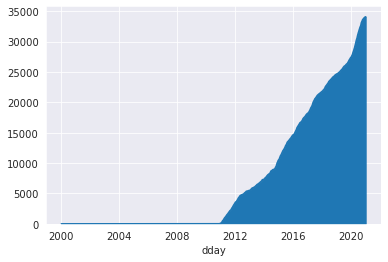

In [ ]:
sumofCommits.loc['rstudio/rstudio'].dropna().plot.area()

<AxesSubplot:xlabel='dday'>

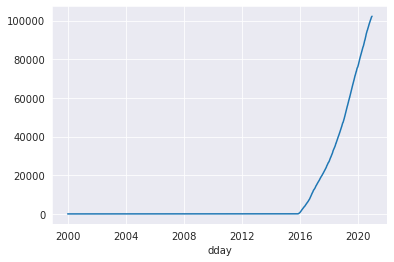

In [ ]:
sumofCommits.loc['tensorflow/tensorflow'].plot()

<AxesSubplot:xlabel='dday'>

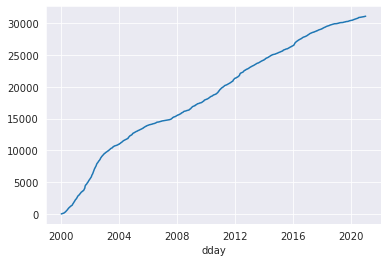

In [ ]:
sumofCommits.loc['apache/httpd'].plot()

<AxesSubplot:xlabel='dday'>

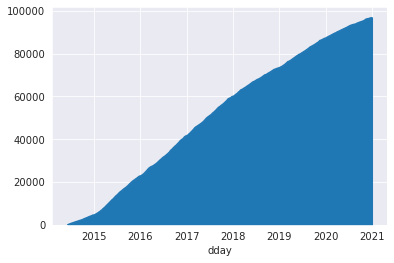

In [ ]:
sumofCommits.where(sumofCommits > 0).loc['kubernetes/kubernetes'].dropna().plot.area()

array([<AxesSubplot:ylabel='0'>], dtype=object)

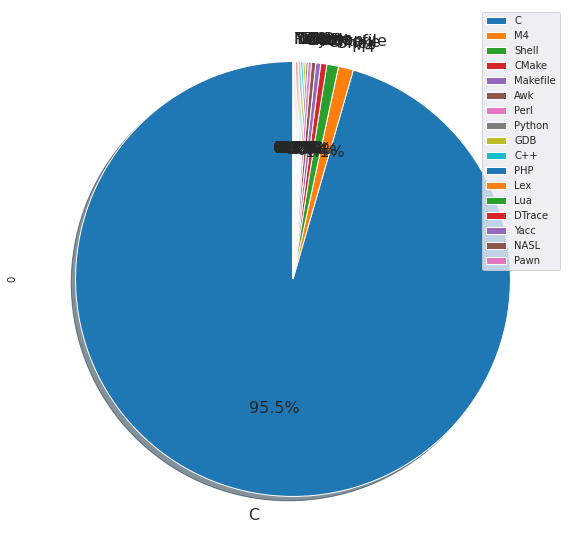

In [ ]:
repo_lang = pd.read_json('https://api.github.com/repos/apache/httpd/languages', orient='index')

repo_lang.plot.pie(figsize=(10,10), autopct='%1.1f%%',
        shadow=True, startangle=90, subplots=True, fontsize=16)

In [ ]:
df.head()

,commit,date,message,repo,dday,wday,day,month,year,hour,min,sec,user,email,is_core_bug
612,c15f3df7b112350e2af19ccc5401601e54c9b722,2020-12-31 23:52:12+00:00,TST/REF: implement tests.frame.constructors (#...,pandas-dev/pandas,2020-12-31,3,31,12,2020,23,52,12,jbrockmendel,jbrockmendel@gmail.com,False
613,48edcad40b467a02f02072677f097dd31a03c016,2020-12-31 23:49:08+00:00,"BUG: DataFrame(dt64data, dtype=td64) corner ca...",pandas-dev/pandas,2020-12-31,3,31,12,2020,23,49,8,jbrockmendel,jbrockmendel@gmail.com,True
614,9b470912e8fea99cd17775d8afc5590ae1eeb50c,2020-12-31 22:13:38+00:00,"TST/REF: io/parser/(test_dtypes.py, test_useco...",pandas-dev/pandas,2020-12-31,3,31,12,2020,22,13,38,Andrew Wieteska,48889395+arw2019@users.noreply.github.com,False
615,bdc5a67db98878c25d6bc8a4b368a43e426a9d2c,2020-12-31 19:11:27+00:00,BUG: unstack with missing levels results in in...,pandas-dev/pandas,2020-12-31,3,31,12,2020,19,11,27,Yuanhao Geng,41546976+GYHHAHA@users.noreply.github.com,True
616,906d3b673cb6ddf99b7f3ee4579b8b8d5128539d,2020-12-31 18:48:27+00:00,Fix broken link in docs (#38854),pandas-dev/pandas,2020-12-31,3,31,12,2020,18,48,27,Felix Divo,felixdivo@users.noreply.github.com,True


In [ ]:
report = df.pivot_table(index='repo', values='message', aggfunc='count', margins=True)
report

,message
repo,
angular/angular,19811
apache/httpd,31102
apache/spark,28951
apple/swift,115792
denoland/deno,4940
facebook/react,13776
freebsd/freebsd-src,211379
gcc-mirror/gcc,157035
golang/go,46284


In [ ]:
users = df.groupby('repo')['user'].nunique()
report = report.join(users)
report

,message,user
repo,,
angular/angular,19811,1471.0
apache/httpd,31102,117.0
apache/spark,28951,2245.0
apple/swift,115792,1008.0
denoland/deno,4940,561.0
facebook/react,13776,1585.0
freebsd/freebsd-src,211379,753.0
gcc-mirror/gcc,157035,1928.0
golang/go,46284,1925.0


In [ ]:
report['user'][-1] = report['user'].dropna().sum()
report['message %'] = (report['message']/report.loc['All']['message']).apply(lambda x: "{:.1%}".format(x))
report['user %'] = (report['user']/report.loc['All']['user']).apply(lambda x: "{:.1%}".format(x))
report

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df['dday'][0:100]

612    2020-12-31
613    2020-12-31
614    2020-12-31
615    2020-12-31
616    2020-12-31
          ...    
707    2020-12-24
708    2020-12-24
709    2020-12-24
710    2020-12-24
711    2020-12-23
Name: dday, Length: 100, dtype: object

In [ ]:
df['week'] = df['dday'].apply(lambda x: x.strftime('%W'))

In [ ]:
week = df.pivot_table(index='repo',columns=['week','year'],values='message', aggfunc='count')

In [ ]:
week.mean(axis=1)

repo
angular/angular                59.314371
apache/httpd                   28.223230
apache/spark                   52.447464
apple/swift                   222.249520
denoland/deno                  35.285714
facebook/react                 34.526316
freebsd/freebsd-src           189.747756
gcc-mirror/gcc                140.964991
golang/go                      68.670623
ipython/ipython                32.864901
jupyterlab/jupyterlab          84.898496
kubernetes/kubernetes         277.372493
llvm/llvm-project             365.270874
matplotlib/matplotlib          41.255482
microsoft/TypeScript           91.848837
microsoft/vscode              273.996337
nginx/nginx                     8.220073
nodejs/node                    52.095694
numpy/numpy                    26.664899
openbsd/src                   166.356373
opencv/opencv                  53.151246
pandas-dev/pandas              44.257391
postgres/postgres              39.824057
python/cpython                 87.113106
pytorch/pyt

In [ ]:
#bugs = df.pivot_table(index='repo', values=['is_core_bug','is_fix'], aggfunc='sum')
bugs = df.pivot_table(index='repo', values=['is_core_bug'], aggfunc='sum')

In [ ]:
bugs = bugs.join(report)

In [ ]:
bugs['is_not_core_bug'] = bugs['message'] - bugs['is_core_bug']

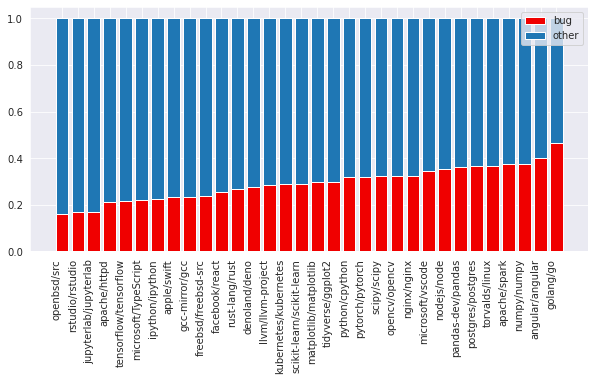

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
fig.autofmt_xdate(rotation=90)
bugs['bug %'] = bugs['is_core_bug']/bugs['message']
bugs['other %'] = bugs['is_not_core_bug']/bugs['message']
bugs = bugs.sort_values('bug %')
ax.bar(bugs.index, bugs['bug %'], label='bug', color='#f00000')
ax.bar(bugs.index, bugs['other %'], label='other', bottom=bugs['bug %'])
ax.legend()